In [12]:
# input - runs scored, balls played, 4s hit, 6s hit
# output - runs in boundary %, balls per boundry, strike rate

#       ------> Strike Rate Calculation (SR)
# START ------> Balls per Boundary Calculation (BPB) ---------------------> Summary --------> END
#       ------> Runs in Boundary Percentage Calculation (RBP)

In [13]:
from langgraph.graph import StateGraph, START, END  
from typing import TypedDict
from euriai.langchain import create_chat_model
from dotenv import load_dotenv
import os
load_dotenv()  # Load environment variables from .env file
api_key = os.getenv("key")  # Retrieve the API key from environment variables

In [14]:
class BatsmanState(TypedDict):
    runs_scored: int
    balls_played: int
    fours_hit: int
    sixes_hit: int
    runs_in_boundary_percentage: float
    balls_per_boundary: float
    strike_rate: float
    summary: str

In [15]:
chat_model = create_chat_model(
    api_key=api_key,
    model="gpt-4.1-nano",
    temperature=0.7
)

In [20]:
def calculate_strike_rate(state: BatsmanState) -> BatsmanState:
    runs_scored = state['runs_scored']
    balls_played = state['balls_played']
    strike_rate = (runs_scored / balls_played) * 100 if balls_played > 0 else 0
    #state['strike_rate'] = strike_rate
    return {"strike_rate": strike_rate}

def calculate_rbp(state: BatsmanState) -> BatsmanState:
    runs_scored = state['runs_scored']
    fours_hit = state['fours_hit']
    sixes_hit = state['sixes_hit']
    runs_in_boundary = fours_hit * 4 + sixes_hit * 6
    runs_in_boundary_percentage = (runs_in_boundary / runs_scored) * 100 if runs_scored > 0 else 0
    #state['runs_in_boundary_percentage'] = runs_in_boundary_percentage
    return {"runs_in_boundary_percentage": runs_in_boundary_percentage}

def calculate_bpb(state: BatsmanState) -> BatsmanState:
    balls_played = state['balls_played']
    fours_hit = state['fours_hit']
    sixes_hit = state['sixes_hit']
    total_boundaries = fours_hit + sixes_hit
    balls_per_boundary = (balls_played / total_boundaries) if total_boundaries > 0 else 0
    #state['balls_per_boundary'] = balls_per_boundary
    return {"balls_per_boundary": balls_per_boundary}

def generate_summary(state: BatsmanState) -> BatsmanState:
    prompt = f"""
    The batsman scored {state['runs_scored']} runs in {state['balls_played']} balls, hitting {state['fours_hit']} fours and {state['sixes_hit']} sixes. 
    The strike rate is {state['strike_rate']:.2f}, the percentage of runs in boundaries is {state['runs_in_boundary_percentage']:.2f}%, and the average number of balls per boundary is {state['balls_per_boundary']:.2f}.
    Write a brief summary of the batsman's performance based on these statistics.
    """
    response = chat_model.invoke(prompt)
    #state['summary'] = response.content
    return {"summary": response.content}

In [21]:
graph = StateGraph(BatsmanState)

graph.add_node("calculate_strike_rate", calculate_strike_rate)
graph.add_node("calculate_rbp", calculate_rbp)
graph.add_node("calculate_bpb", calculate_bpb)
graph.add_node("generate_summary", generate_summary)

graph.add_edge(START, "calculate_strike_rate")
graph.add_edge(START, "calculate_rbp")
graph.add_edge(START, "calculate_bpb")

graph.add_edge("calculate_strike_rate", "generate_summary")
graph.add_edge("calculate_rbp", "generate_summary")
graph.add_edge("calculate_bpb", "generate_summary")

graph.add_edge("generate_summary", END)

## compile the graph
workflow = graph.compile()

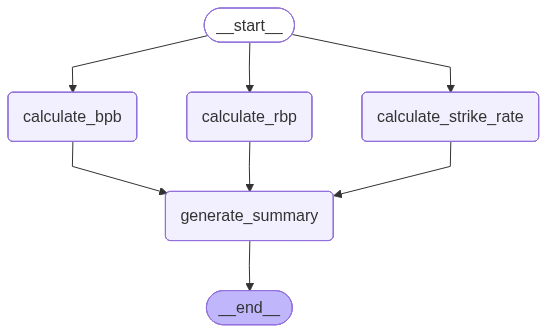

In [22]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [23]:
## execute the workflow
initial_state = {"runs_scored": 100, "balls_played": 50, "fours_hit": 10, "sixes_hit": 5}
final_state = workflow.invoke(initial_state)  

In [24]:
final_state

{'runs_scored': 100,
 'balls_played': 50,
 'fours_hit': 10,
 'sixes_hit': 5,
 'runs_in_boundary_percentage': 70.0,
 'balls_per_boundary': 3.3333333333333335,
 'strike_rate': 200.0,
 'summary': 'The batsman delivered an impressive performance, scoring 100 runs off just 50 balls with a striking strike rate of 200.00. He hit 10 fours and 5 sixes, contributing significantly to his total runs, with boundaries accounting for 70% of his total score. On average, he hit a boundary every 3.33 balls, showcasing his ability to score quickly and efficiently. Overall, his aggressive batting display highlights his prowess in maximizing scoring opportunities during the innings.'}